<a href="https://colab.research.google.com/github/Paradiddle131/Translating-Sign-Language-to-Text-and-Audio/blob/master/TSL_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Yapilacaklar:
- remove black edges

## Download Data

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Core Functions

In [0]:
def mkdir(path):
  try:
    os.makedirs(path, exist_ok=True)
  except OSError:
    print("Folder already exists. Passing.")
    pass

In [0]:
def copy(From, to):
  if not os.path.isdir(to):
    os.mkdir(to)
  files = sorted(os.listdir(From))
  for f in files:
    shutil.copy(f'{From}/{f}', to)

In [0]:
def remove_files(path):
  for filename in os.listdir(path):
    file_path = os.path.join(path, filename)
    try:
        if os.path.isfile(file_path):
            os.remove(file_path)
    except Exception as e:
        print('Failed to delete %s. Reason: %s' % (file_path, e))

In [0]:
def count_files(path):
  return len(next(os.walk(path))[2])

## Import Libraries

In [0]:
import os
import shutil
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np

In [0]:
ROOT = '/content/'
VID_DIR = os.path.join(ROOT, 'data/vid/cut/')
FRAMES_DIR = os.path.join(VID_DIR, 'frames/')
FRAMES_RESIZED_DIR = os.path.join(VID_DIR, 'frames_resized/')
TARGET_SIZE = (180, 120)

## Extract Frames From Videos

In [0]:
mkdir(os.path.join(VID_DIR))
copy('/content/drive/My Drive/Dataset/fingers_dataset/cut/', VID_DIR)

In [0]:
mkdir(FRAMES_DIR)
for finger_no, vid in enumerate(sorted(glob.glob(VID_DIR+'*.mp4')), 1):
  i = 0
  path = FRAMES_DIR+str(finger_no)
  mkdir(path)
  cap = cv2.VideoCapture(vid)
  while(cap.isOpened()):
      ret, frame = cap.read()
      if ret == False:
          break
      cv2.imwrite(path+'/'+str(i)+'.jpg', frame)
      i += 1
 
cap.release()
cv2.destroyAllWindows()

In [0]:
# [remove_files(folder) for folder in glob.glob('/content/data/vid/cut/frames/*')]

## Data Analysis

Examine a Sample and Notice the Black Edges

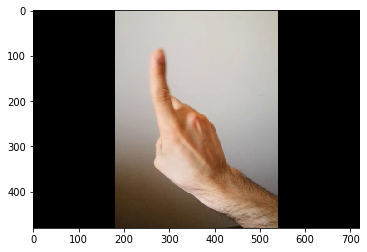

In [0]:
path = '/content/data/vid/cut/frames/1/0.jpg'
img = cv2.imread(path)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

TypeError: ignored

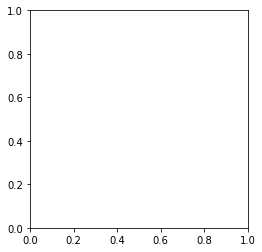

In [0]:
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
_,thresh = cv2.threshold(gray,1,255,cv2.THRESH_BINARY)
contours,hierarchy = cv2.findContours(thresh,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
plt.imshow(contours, cmap='gray')
# cnt = contours[0]
# x,y,w,h = cv2.boundingRect(cnt)
# crop = img[y:y+h,x:x+w]
# # plt.imshow(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))
# cv2.imwrite('/content/crop.png', crop)

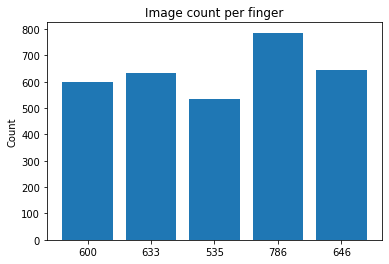

In [0]:
values = [[(i, count_files(folder)) for i, folder in enumerate(glob.glob(FRAMES_DIR+'*'))][i][1] for i in range(5)]
y_pos = np.arange(1, len(values)+1)

plt.bar(y_pos, values, align='center')
plt.xticks(y_pos, values)
plt.ylabel('Count')
plt.title('Image count per finger')

plt.show()

Dimension Check

In [0]:
shapes = {}
i = 0
previous_shape = None
for folder in glob.glob(FRAMES_DIR+'*'):
  for file in glob.glob(folder+'/*'):
    img = cv2.imread(file)
    shape = img.shape
    if previous_shape != shape:
      previous_shape = shape
      i += 1
    shapes.update({i: previous_shape})
print(shapes)
if len(shapes) == 1:
  print(f"All images' shapes are equal to {img.shape}.")

{1: (480, 720, 3)}
All images' shapes are equal to (480, 720, 3).


Resize Images

In [0]:
os.path.join(FRAMES_RESIZED_DIR, '*.jpg')

'/content/data/vid/cut/frames_resized/*.jpg'

In [0]:
mkdir(FRAMES_RESIZED_DIR)
for finger_no, folder in enumerate(sorted(os.listdir(FRAMES_DIR)), 1):
  i = 0
  # print(folder)
  finger_path = os.path.join(FRAMES_DIR, folder)
  finger_resized_path = os.path.join(FRAMES_RESIZED_DIR, folder)
  # print(finger_path)
  # print('mkdir', finger_resized_path)
  mkdir(finger_resized_path)
  # for file in sorted(glob.glob(os.path.join(finger_path, '*.jpg'))):
  for file in sorted(os.listdir(finger_path)):
    # print(file)
    path = os.path.join(finger_path, file)
    print(os.path.join(finger_resized_path, file))
    img = cv2.imread(path)
    print(img.shape)
    img = cv2.resize(img, TARGET_SIZE)
    print(img.shape)
    cv2.imwrite(os.path.join(finger_resized_path, file), img)
    # i += 1
    break
  break

/content/data/vid/cut/frames_resized/1/0.jpg
(480, 720, 3)
(120, 180, 3)
